# Setup Notebook for fast ai

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 7.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 194kB 14.3MB/s 
     |████████████████████████████████| 1.2MB 19.1MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/project/HackerEarth/STILLthe_season_to_be_jolly

/content/gdrive/MyDrive/project/HackerEarth/STILLthe_season_to_be_jolly


In [ ]:
!ls

alexnet.csv	    requirements_updates.txt  v2_densenet201.csv
dataset		    resnet101.csv	      v2_resnet101.csv
dataset.zip	    resnet152.csv	      v2_resnet152.csv
fastai_1_7_gpu.txt  resnet34.csv	      v2_resnet34.csv
requirements.txt    resnet50.csv	      v2_vgg16_bn.csv


# Imports

In [ ]:
import fastai
import torch
import torchvision
import fastbook
print("Fastbook : ",fastbook.__version__)
print("torchvision : ",torchvision.__version__)
print("torch : ",torch.__version__)
print("fastai : ",fastai.__version__)

Fastbook :  0.0.16
torchvision :  0.8.1+cu101
torch :  1.7.0+cu101
fastai :  2.2.5


In [ ]:
import numpy as np
import torch
from fastai import *
from fastai.vision.all import *
from fastai.callback.all import *

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Augmentation


In [ ]:
def get_dls(bs, size, val_idx):
    item_tfms = Resize(300)
    batch_tfms = [RandomResizedCrop(size), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]
    dls = ImageDataLoaders.from_df(train_df, path/"train", 
                              splitter=IndexSplitter(val_idx),
                              item_tfms=item_tfms,
                              batch_tfms = batch_tfms,
                              bs=bs, num_workers=4, 
                              label_col="Class")
    return dls

In [ ]:
path = Path('/content/gdrive/MyDrive/project/HackerEarth/STILLthe_season_to_be_jolly/dataset')
train = path /"train.csv"
train_df = pd.read_csv(train)
train_df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [ ]:
item_tfms = RandomResizedCrop(400,min_scale=0.75,ratio=(1.,1.))
batch_tfms = [ *aug_transforms(size=224,mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]

In [ ]:
dls = ImageDataLoaders.from_df(train_df, path/"train", 
                              item_tfms=item_tfms,
                              batch_tfms = batch_tfms,
                              bs=64, num_workers=4, 
                              label_col="Class")

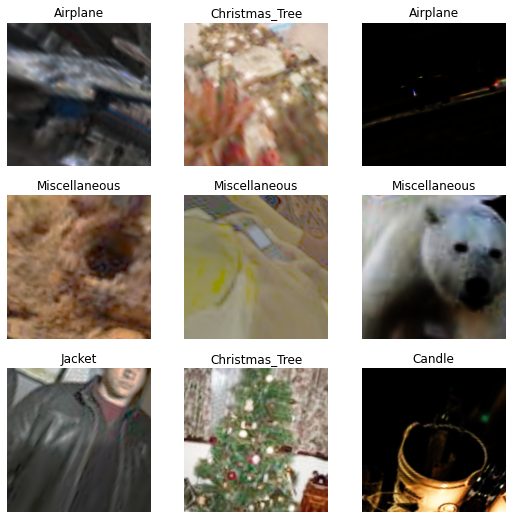

In [ ]:
dls.train.show_batch()

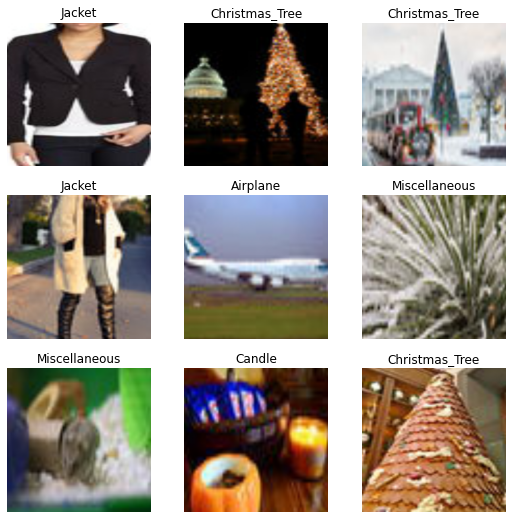

In [ ]:
dls.valid.show_batch()

In [ ]:
# category names, number of categories
print(dls.vocab); print(dls.c)

['Airplane', 'Candle', 'Christmas_Tree', 'Jacket', 'Miscellaneous', 'Snowman']
6


# Custom scoring

In [ ]:
acc_02 = partial(accuracy_multi, thresh=0.2)
f_score = partial(FBeta, thresh=0.2)

# Learner

In [ ]:
learn = cnn_learner(dls, resnet152, metrics=[F1Score(average='weighted'),accuracy], model_dir="/tmp/model/").to_fp16()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
test_files = get_image_files('/content/gdrive/MyDrive/project/HackerEarth/STILLthe_season_to_be_jolly/dataset/test') 
dl2 = learn.dls.test_dl(test_files)

In [ ]:
ROOT = "/content/gdrive/MyDrive/project/HackerEarth/STILLthe_season_to_be_jolly/dataset"

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings(action='ignore')

# K fold cross validation


(6469, 2)
Starting fold 0
(6064,) (405,)


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,2.005007,0.854854,0.737470,0.264501,0.735499,02:03


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.481956,0.462777,0.852097,0.149265,0.850735,02:29
1,1.300576,0.408552,0.869374,0.129930,0.870070,02:29


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.241838,0.390493,0.871637,0.127610,0.872390,02:08


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.250973,0.386166,0.872177,0.126837,0.873163,02:29
1,1.293267,0.382226,0.880111,0.119103,0.880897,02:29
2,1.216310,0.390913,0.872747,0.126837,0.873163,02:29
3,1.238328,0.382694,0.878882,0.119876,0.880124,02:29


No improvement since epoch 1: early stopping


0.8522815108299255


F1 score for this fold  0.8541283957024052


Starting fold 1
(6064,) (405,)


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.990942,0.904921,0.719567,0.283063,0.716937,02:03


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.540582,0.630841,0.797940,0.201083,0.798917,02:28
1,1.282266,0.394874,0.859683,0.140758,0.859242,02:29


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.208115,0.360126,0.883613,0.116783,0.883217,02:08


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.208791,0.374707,0.872046,0.128384,0.871616,02:29
1,1.181056,0.365141,0.877165,0.122970,0.877030,02:28
2,1.188500,0.348519,0.880394,0.119876,0.880124,02:29
3,1.152888,0.345432,0.884671,0.115236,0.884764,02:29
4,1.161291,0.335004,0.887036,0.112916,0.887084,02:29


0.8839907050132751


F1 score for this fold  0.8767342289466151


Starting fold 2
(6064,) (405,)


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.874090,0.677352,0.756188,0.240526,0.759474,02:04


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.269212,0.493906,0.822500,0.177107,0.822892,02:30
1,1.091051,0.438162,0.845269,0.153132,0.846868,02:28


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.031263,0.334258,0.885932,0.113689,0.886311,02:09


epoch,train_loss,valid_loss,f1_score,error_rate,accuracy,time
0,1.037308,0.325084,0.889241,0.110596,0.889404,02:29
1,1.015690,0.315349,0.891551,0.108275,0.891725,02:29
2,0.999506,0.314252,0.890779,0.109049,0.890951,02:28
3,0.996120,0.316388,0.893198,0.106729,0.893271,02:29
4,1.002102,0.314249,0.888553,0.111369,0.888631,02:29


0.8808971643447876


F1 score for this fold  0.8864590365910453


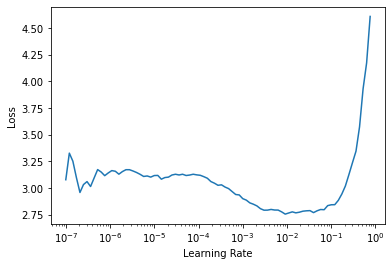

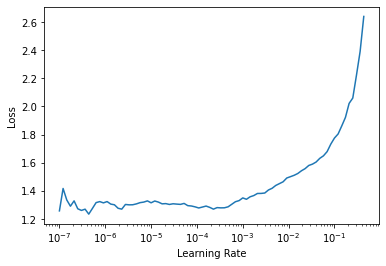

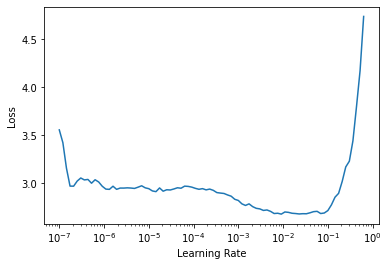

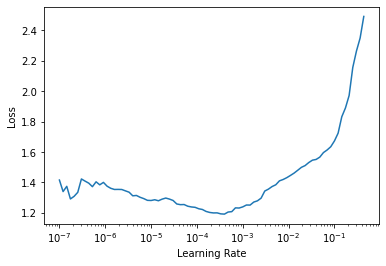

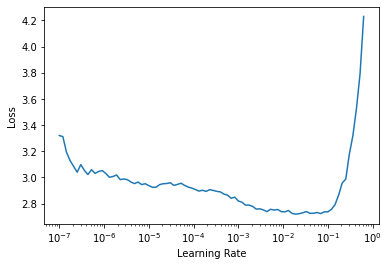

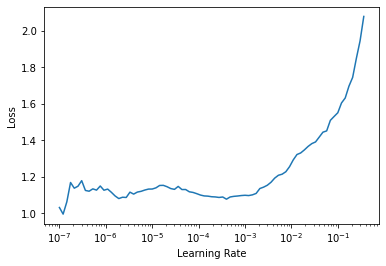

In [ ]:
if __name__=="__main__":
    #train_df, test_df = read_data(ROOT)
    print(train_df.shape)    
    cvlist = list(StratifiedKFold(16, random_state=42).split(train_df, train_df.Class))    
    test_preds_all = []
    val_preds_all = []
    for i in range(3):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        dls = get_dls(32, 128, val_idx)
        learn = cnn_learner(dls, resnet152, metrics=[F1Score(average='weighted'),error_rate,accuracy], cbs=MixUp, model_dir="/tmp/model/").to_fp16()
        lr_min,lr_max = learn.lr_find()
        learn.fine_tune(2,lr_min)
        learn.dls = get_dls(32, 224, val_idx)
        lr_min,lr_max = learn.lr_find()
        learn.fine_tune(5, lr_min, cbs=EarlyStoppingCallback(patience=2))
        preds,targs = learn.tta()
        print(accuracy(preds, targs).item())
        #val_pct.append(accuracy(preds, targs).item())
        val_preds, y = learn.tta()
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.tta(dl=dl2)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)